In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

/home/ian/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
base = pd.read_csv('../data/adjusted_stats_modeling_base_df.csv')
model = load('../modeling/game_outcome_modeling/saved_models/xg_boost_kinda_ok_av.joblib')
# feature_list = ['qb_adjusted_value_home', 'rushing_adjusted_value_home', 'qb_def_adjusted_value_home', 'rush_def_adjusted_value_home', 'special_teams_value_home',
#                    'qb_adjusted_value_away', 'rushing_adjusted_value_away', 'qb_def_adjusted_value_away', 'rush_def_adjusted_value_away', 'special_teams_value_away']
feature_list =['passing_value_adjusted_home', 'rushing_value_adjusted_home', 'pass_def_value_adjusted_home', 'rush_def_value_adjusted_home', 'special_teams_value_home',
          'passing_value_adjusted_away', 'rushing_value_adjusted_away', 'pass_def_value_adjusted_away', 'rush_def_value_adjusted_away', 'special_teams_value_away']

In [3]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [4]:
base['home_win_pred'] = win_preds
base['home_win_prob'] = win_probs[:,1]
base['away_win_prob'] = win_probs[:,0]

In [5]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

# analysis_df = base[base.season != 2022]
analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)
analysis_df.head()

/tmp/ipykernel_215977/963007458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score,away_score,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,home_win,home_win_pred,home_win_prob,away_win_prob,pred_correct
2146,2154,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0,1,0.545456,0.454544,0
2147,2155,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,1,1,0.888267,0.111733,1
2150,2158,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,0,1,0.928819,0.071181,0
2153,2161,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,0,0,0.429646,0.570354,1
2154,2162,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,1,0,0.234202,0.765798,0


In [6]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.home_win, analysis_df.home_win_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.home_win, analysis_df.home_win_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.6008230452674898
Precision: 0.6433566433566433
Recall: 0.6666666666666666

True Positive Rate: 0.6666666666666666
False Positive Rate: 0.4857142857142857
True Negative Rate: 0.5142857142857142
False Negative Rate: 0.3333333333333333


In [7]:
# Get NFL translated accuracy stats

home_win_pct = sum(analysis_df.home_win==1)/len(analysis_df)
away_win_pct = sum(analysis_df.home_win==0)/len(analysis_df)

home_win_pred_pct = sum(analysis_df.home_win_pred==1)/len(analysis_df)
away_win_pred_pct = sum(analysis_df.home_win_pred==0)/len(analysis_df)

print('Home Win Percentage: {}'.format(home_win_pct))
print('Away Win Percentage: {}'.format(away_win_pct))
print('Home Win Predicted Percentage: {}'.format(home_win_pred_pct))
print('Away Win Predicted Percentage: {}'.format(away_win_pred_pct))

Home Win Percentage: 0.5679012345679012
Away Win Percentage: 0.43209876543209874
Home Win Predicted Percentage: 0.588477366255144
Away Win Predicted Percentage: 0.411522633744856


<Axes: >

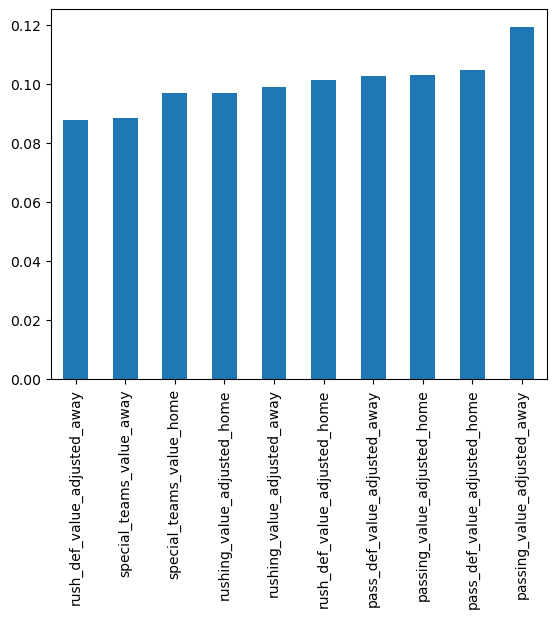

In [8]:
# Feature Importance

importances = pd.Series(model.feature_importances_, index = feature_list).sort_values()
importances.plot.bar()

In [9]:
home_wins = analysis_df[analysis_df.home_win==1]
away_wins = analysis_df[analysis_df.home_win==0]

home_win_acc = accuracy_score(home_wins.home_win, home_wins.home_win_pred)
away_win_acc = accuracy_score(away_wins.home_win, away_wins.home_win_pred)

home_wins_pred = analysis_df[analysis_df.home_win_pred==1]
away_wins_pred = analysis_df[analysis_df.home_win_pred==0]

home_win_pred_acc = accuracy_score(home_wins_pred.home_win, home_wins_pred.home_win_pred)
away_win_pred_acc = accuracy_score(away_wins_pred.home_win, away_wins_pred.home_win_pred)

print('Accuracy for Home Wins: {}'.format(home_win_acc))
print('Accuracy for Away Wins: {}'.format(away_win_acc))
print()
print('Accuracy for Home Wins Predicted: {}'.format(home_win_pred_acc))
print('Accuracy for Away Wins Predicted: {}'.format(away_win_pred_acc))

Accuracy for Home Wins: 0.6666666666666666
Accuracy for Away Wins: 0.5142857142857142

Accuracy for Home Wins Predicted: 0.6433566433566433
Accuracy for Away Wins Predicted: 0.54


<Axes: xlabel='home_win_prob', ylabel='home_win'>

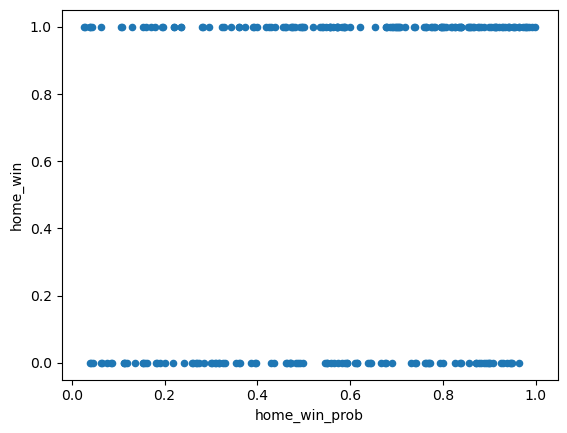

In [10]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='home_win_prob', y='home_win')

      correct_preds  total_games  accuracy
week                                      
1                 4           10  0.400000
2                 7           15  0.466667
3                 9           16  0.562500
4                 8           12  0.666667
5                11           15  0.733333
6                 6           13  0.461538
7                 9           13  0.692308
8                 8           13  0.615385
9                 8           11  0.727273
10                7           14  0.500000
11                9           14  0.642857
12                9           13  0.692308
13                4           11  0.363636
14                7           10  0.700000
15               11           15  0.733333
16                6           14  0.428571
17                6           10  0.600000
18                9           12  0.750000
19                5            6  0.833333
20                2            4  0.500000
21                1            1  1.000000
22         

<Axes: xlabel='week'>

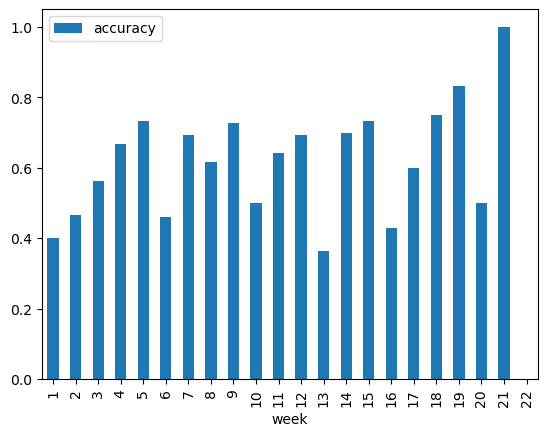

In [11]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [12]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df.groupby(by=['pred_correct', 'home_win']).mean()[['home_win_prob', 'away_win_prob']]
pred_confs

/tmp/ipykernel_215977/367605149.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_confs = analysis_df.groupby(by=['pred_correct', 'home_win']).mean()[['home_win_prob', 'away_win_prob']]


home_win_prob  away_win_prob
pred_correct home_win                              
0            0              0.758090       0.241910
             1              0.296891       0.703109
1            0              0.268269       0.731731
             1              0.782252       0.217748

In [13]:
# Bring in the gambling data, see how we would have fared with actual betting
# Also, compare accuracy for favorites, underdogs, etc.

betting = pd.read_csv('../data/betting_data_cleaned_with_returns.csv')
betting = betting.drop(columns=['Unnamed: 0'])

In [14]:
game_probs = base[['date', 'season', 'week', 'home', 'away', 'home_win', 'home_win_pred', 'home_win_prob', 'away_win_prob']]

In [15]:
len(game_probs)

2088

In [16]:
game_with_lines = betting.merge(game_probs, left_on=['date', 'home_team', 'away_team'], right_on=['date', 'home', 'away'])

In [17]:
game_with_lines['home_line_advantage'] = game_with_lines.apply(lambda x: x.home_win_prob-x.home_implied_prob, axis=1)
game_with_lines['away_line_advantage'] = game_with_lines.apply(lambda x: x.away_win_prob-x.away_implied_prob, axis=1)
# game_with_lines

In [53]:
def get_algo_returns(game, threshold_low, threshold_high):
    if game.home_line_advantage > game.away_line_advantage:
        bet_team = 'home'
        bet_advantage = game.home_line_advantage
    else:
        bet_team = 'away'
        bet_advantage = game.away_line_advantage
        
    if threshold_low <= bet_advantage <= threshold_high:
        return game['{}_return'.format(bet_team)]
    
    else:
        return 0
    
    
threshold_low = 0.15
threshold_high = 1
threshold_var = threshold_low

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold_low, threshold_high), axis=1)

In [54]:
game_with_lines = game_with_lines[game_with_lines.season == 2022]
game_with_lines

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.870911,0.129089,0.325457,-0.370911,-100.00
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.572215,0.427785,0.006998,-0.048406,0.00
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.856845,0.143155,0.190179,-0.227216,50.00
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.882335,0.117665,0.160113,-0.199796,-100.00
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,0,0.455943,0.544057,-0.335724,0.294057,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,0,0.234202,0.765798,-0.068828,0.024865,0.00
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,0,0.429646,0.570354,0.090663,-0.133788,0.00
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.888267,0.111733,0.255914,-0.288267,58.14
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,1,0.928819,0.071181,0.634702,-0.680680,-100.00


In [55]:
# How does accuracy change when the confidence thresholds are adjusted?

# thresholds = [0, .01, .02, .03, .05, .06, .07, .085, .1, .125, .15, .2]
thresholds = [0, .05, .10, .15, .2, .25, .3, .35, .4, .45, .5]
accuracies = []
num_games_bet = []

for threshold in thresholds:
    threshold_df = game_with_lines[np.abs(game_with_lines.home_line_advantage) >= threshold]
    accuracy = accuracy_score(threshold_df.home_win, threshold_df.home_win_pred)
    
    accuracies.append(accuracy)
    num_games_bet.append(len(threshold_df))

In [56]:
accuracies

[0.5991735537190083,
 0.5887850467289719,
 0.5879120879120879,
 0.581081081081081,
 0.584070796460177,
 0.5393258426966292,
 0.49230769230769234,
 0.40425531914893614,
 0.4358974358974359,
 0.30434782608695654,
 0.21428571428571427]

In [57]:
num_games_bet

[242, 214, 182, 148, 113, 89, 65, 47, 39, 23, 14]

In [58]:
# Test Season total return

# test_with_lines = game_with_lines[game_with_lines.season != 2022]
test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

1796.2500000000002

/tmp/ipykernel_215977/1829231814.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='week'>

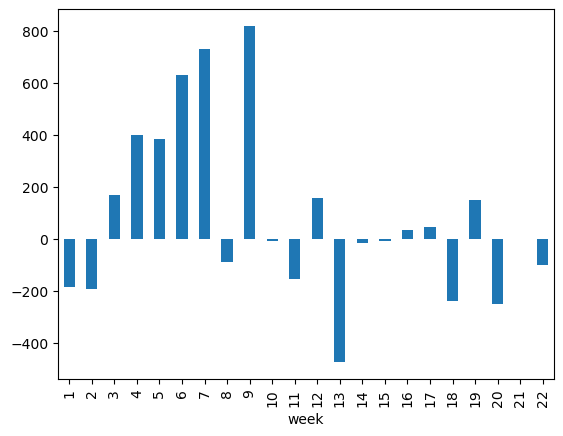

In [59]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

/tmp/ipykernel_215977/1502147613.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='season'>

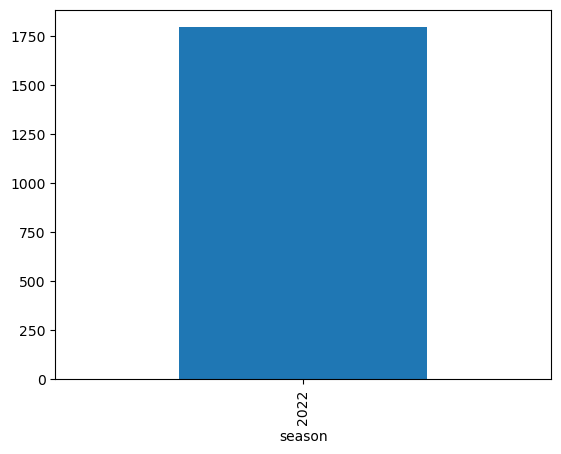

In [60]:
# Season by season return 
test_with_lines.groupby(by='season').sum()['algo_return'].plot.bar()

In [61]:
test_with_lines[test_with_lines.week == 11]

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
96,2022-11-21,Arizona Cardinals,San Francisco 49ers,10,38,48,350.0,-455.0,10.0,-10.0,43.0,over,28,-28,away,0.222222,0.819820,away,21.98,-100.0,-100.00,21.98,90.91,-100.00,-100.00,90.91,90.91,-100.00,2022,11,Arizona Cardinals,San Francisco 49ers,0,0,0.261262,0.738738,0.039040,-0.081082,0.00
97,2022-11-20,Los Angeles Chargers,Kansas City Chiefs,27,30,57,195.0,-238.0,5.5,-5.5,53.0,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,11,Los Angeles Chargers,Kansas City Chiefs,0,0,0.085230,0.914770,-0.253753,0.210628,42.02
98,2022-11-20,Minnesota Vikings,Dallas Cowboys,3,40,43,110.0,-132.0,2.0,-2.0,48.5,under,37,-37,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,11,Minnesota Vikings,Dallas Cowboys,0,1,0.593267,0.406733,0.117077,-0.162233,0.00
99,2022-11-20,Pittsburgh Steelers,Cincinnati Bengals,30,37,67,160.0,-182.0,3.5,-3.5,39.5,over,7,-7,away,0.384615,0.645390,away,54.95,-100.0,-100.00,54.95,90.91,-100.00,-100.00,90.91,90.91,-100.00,2022,11,Pittsburgh Steelers,Cincinnati Bengals,0,0,0.492832,0.507168,0.108216,-0.138222,0.00
100,2022-11-20,Denver Broncos,Las Vegas Raiders,16,22,38,-152.0,130.0,-2.5,2.5,41.5,under,6,-6,away,0.603175,0.434783,away,-100.00,130.0,-100.00,130.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,11,Denver Broncos,Las Vegas Raiders,0,1,0.642009,0.357991,0.038835,-0.076792,0.00
101,2022-11-20,Atlanta Falcons,Chicago Bears,27,24,51,-141.0,120.0,-2.5,2.5,48.5,over,-3,3,home,0.585062,0.454545,home,70.92,-100.0,70.92,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,11,Atlanta Falcons,Chicago Bears,1,1,0.677984,0.322016,0.092922,-0.132530,0.00
102,2022-11-20,Baltimore Ravens,Carolina Panthers,13,3,16,-714.0,500.0,-12.5,12.5,41.5,under,-10,10,away,0.877150,0.166667,home,14.01,-100.0,14.01,-100.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,11,Baltimore Ravens,Carolina Panthers,1,1,0.973693,0.026307,0.096543,-0.140360,0.00
103,2022-11-20,Buffalo Bills,Cleveland Browns,31,23,54,-370.0,290.0,-7.5,7.5,50.5,over,-8,8,home,0.787234,0.256410,home,27.03,-100.0,27.03,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,11,Buffalo Bills,Cleveland Browns,1,1,0.699929,0.300071,-0.087305,0.043661,0.00
104,2022-11-20,Houston Texans,Washington Football Team,10,23,33,140.0,-161.0,3.0,-3.0,41.0,under,13,-13,away,0.416667,0.616858,away,62.11,-100.0,-100.00,62.11,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,11,Houston Texans,Washington Football Team,0,1,0.638487,0.361513,0.221820,-0.255345,-100.00
105,2022-11-20,Indianapolis Colts,Philadelphia Eagles,16,17,33,240.0,-303.0,6.0,-6.0,45.0,under,1,-1,home,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,11,Indianapolis Colts,Philadelphia Eagles,0,0,0.063601,0.936399,-0.230517,0.184538,33.00


In [62]:
# Should move these to helper functions later

def get_algo_returns_home(game, threshold_low, threshold_high):
    if threshold_low <= game.home_line_advantage <= threshold_high:
        return game.home_return
    
    else:
        return 0
    
def get_algo_returns_away(game, threshold_low, threshold_high):
    if threshold_low <= game.away_line_advantage <= threshold_high:
        return game.away_return
    
    else:
        return 0
    
def get_algo_returns_favorite(game, threshold_low, threshold_high):
    if game.home_moneyline < game.away_moneyline:
        favorite = 'home'
    else:
        favorite = 'away'
        
    if threshold_low <= game['{}_line_advantage'.format(favorite)] <= threshold_high:
        return game.favorite_return 
    
    else:
        return 0
    
def get_algo_returns_underdog(game, threshold_low, threshold_high):
    if game.home_moneyline > game.away_moneyline:
        underdog = 'home'
    else:
        underdog = 'away'
        
    if threshold_low <= game['{}_line_advantage'.format(underdog)] <= threshold_high:
        return game.underdog_return
    
    else:
        return 0 
    
def get_algo_returns_home_favorite(game, threshold_low, threshold_high):
    if game.home_moneyline < game.away_moneyline:
        favorite = 'home'
    else:
        return 0
        
    if threshold_low <= game['{}_line_advantage'.format(favorite)] <= threshold_high:
        return game.favorite_return
    
    else:
        return 0
    
def get_algo_returns_home_underdog(game, threshold_low, threshold_high):
    if game.home_moneyline > game.away_moneyline:
        underdog = 'home'
    else:
        return 0
        
    if threshold_low <= game['{}_line_advantage'.format(underdog)] <= threshold_high:
        return game.underdog_return 
    
    else:
        return 0
    
def get_algo_returns_away_favorite(game, threshold_low, threshold_high):
    if game.home_moneyline < game.away_moneyline:
        return 0
    else:
        favorite = 'away'
        
    if threshold_low <= game['{}_line_advantage'.format(favorite)] <= threshold_high:
        return game.favorite_return
    
    else:
        return 0
    
def get_algo_returns_away_underdog(game, threshold_low, threshold_high):
    if game.home_moneyline > game.away_moneyline:
        return 0
    else:
        underdog = 'away'
        
    if threshold_low <= game['{}_line_advantage'.format(underdog)] <= threshold_high:
        return game.underdog_return 
    
    else:
        return 0
    
threshold = threshold_var

test_with_lines['algo_return_home'] = test_with_lines.apply(lambda x: get_algo_returns_home(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_away'] = test_with_lines.apply(lambda x: get_algo_returns_away(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_favorite(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_underdog(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_home_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_home_favorite(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_away_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_away_favorite(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_home_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_home_underdog(x, threshold_low, threshold_high), axis=1)
test_with_lines['algo_return_away_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_away_underdog(x, threshold_low, threshold_high), axis=1)
test_with_lines

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_return_home_favorite,algo_return_away_favorite,algo_return_home_underdog,algo_return_away_underdog
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.870911,0.129089,0.325457,-0.370911,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.572215,0.427785,0.006998,-0.048406,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.856845,0.143155,0.190179,-0.227216,50.00,50.00,0.0,50.00,0.0,50.00,0.0,0.0,0.0
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.882335,0.117665,0.160113,-0.199796,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,0,0.455943,0.544057,-0.335724,0.294057,-100.00,0.00,-100.0,0.00,-100.0,0.00,0.0,0.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,0,0.234202,0.765798,-0.068828,0.024865,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,0,0.429646,0.570354,0.090663,-0.133788,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.888267,0.111733,0.255914,-0.288267,58.14,58.14,0.0,58.14,0.0,58.14,0.0,0.0,0.0
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,1,0.928819,0.071181,0.634702,-0.680680,-100.00,-100.00,0.0,0.00,-100.0,0.00,0.0,-100.0,0.0


In [63]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog'],
             var_name='algo_return_type', value_name='return')
test_pivoted

/tmp/ipykernel_215977/817734139.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,week,algo_return_type,return
0,1,algo_return_home,-86.91
1,2,algo_return_home,108.16
2,3,algo_return_home,-84.95
3,4,algo_return_home,65.79
4,5,algo_return_home,76.99
...,...,...,...
83,18,algo_return_underdog,-265.00
84,19,algo_return_underdog,150.00
85,20,algo_return_underdog,-200.00
86,21,algo_return_underdog,0.00


<Axes: >

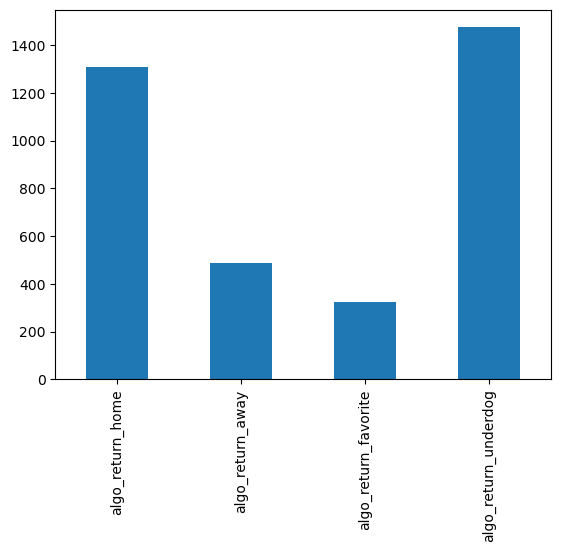

In [64]:
test_with_lines.sum()[['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog']].plot.bar()

<Axes: >

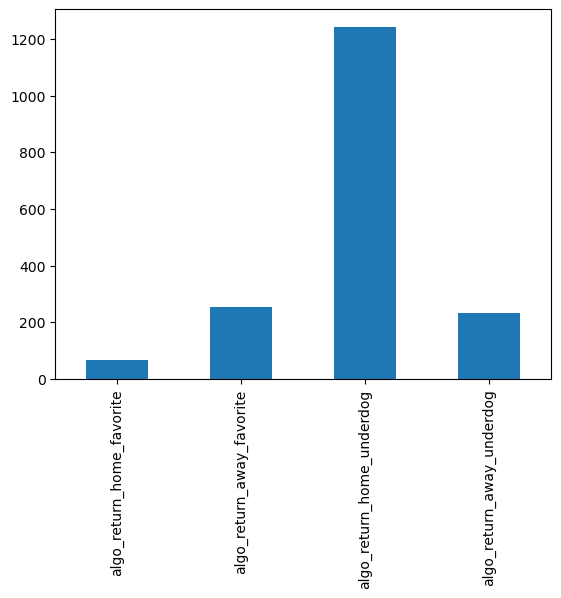

In [65]:
test_with_lines.sum()[['algo_return_home_favorite', 'algo_return_away_favorite', 'algo_return_home_underdog', 'algo_return_away_underdog']].plot.bar()

In [66]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [67]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_home_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_home'), axis=1)
test_with_lines['algo_away_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_away'), axis=1)
test_with_lines['algo_favorite_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_favorite'), axis=1)
test_with_lines['algo_underdog_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_underdog'), axis=1)
test_with_lines

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_return_home_favorite,algo_return_away_favorite,algo_return_home_underdog,algo_return_away_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.870911,0.129089,0.325457,-0.370911,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.572215,0.427785,0.006998,-0.048406,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.856845,0.143155,0.190179,-0.227216,50.00,50.00,0.0,50.00,0.0,50.00,0.0,0.0,0.0,1.0,NaN,1.0,NaN
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.882335,0.117665,0.160113,-0.199796,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,0,0.455943,0.544057,-0.335724,0.294057,-100.00,0.00,-100.0,0.00,-100.0,0.00,0.0,0.0,-100.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,0,0.234202,0.765798,-0.068828,0.024865,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,0,0.429646,0.570354,0.090663,-0.133788,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.888267,0.111733,0.255914,-0.288267,58.14,58.14,0.0,58.14,0.0,58.14,0.0,0.0,0.0,1.0,NaN,1.0,NaN
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,1,0.928819,0.071181,0.634702,-0.680680

In [68]:
accs = test_with_lines.groupby(by='week').agg(
    algo_home_correct = ('algo_home_acc', 'sum'),
    algo_home_total = ('algo_home_acc', 'count'),
    algo_away_correct = ('algo_away_acc', 'sum'),
    algo_away_total = ('algo_away_acc', 'count'),
    algo_favorite_correct = ('algo_favorite_acc', 'sum'),
    algo_favorite_total = ('algo_favorite_acc', 'count'),
    algo_underdog_correct = ('algo_underdog_acc', 'sum'),
    algo_underdog_total = ('algo_underdog_acc', 'count')
)

accs['algo_home_acc'] = accs.algo_home_correct/accs.algo_home_total
accs['algo_away_acc'] = accs.algo_away_correct/accs.algo_away_total
accs['algo_favorite_acc'] = accs.algo_favorite_correct/accs.algo_favorite_total
accs['algo_underdog_acc'] = accs.algo_underdog_correct/accs.algo_underdog_total

<Axes: xlabel='week'>

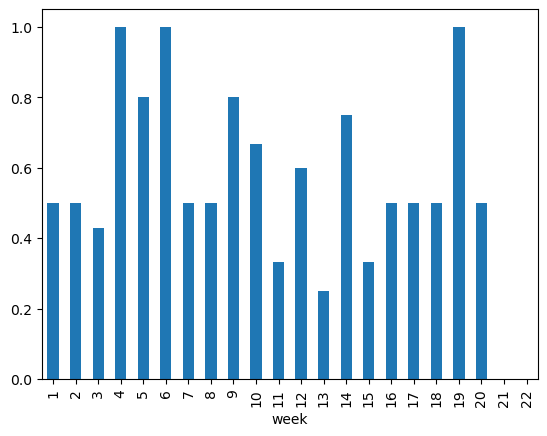

In [69]:
check_col = 'algo_home_acc'
accs[check_col].plot.bar()

<Axes: >

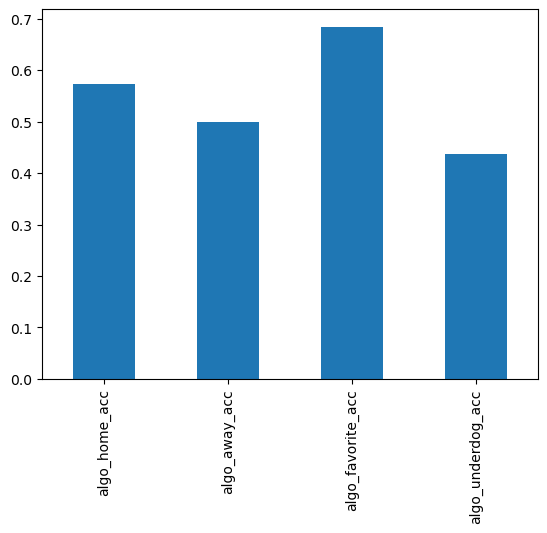

In [70]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_home_acc', 'algo_away_acc', 'algo_favorite_acc', 'algo_underdog_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [71]:
# Total bet counts

len(test_with_lines[test_with_lines.algo_return != 0])

137

In [72]:
test_with_lines[test_with_lines.algo_return!=0][['date', 'week', 'home_team', 'away_team', 'home_score', 'away_score', 'algo_return', 'home_line_advantage', 'away_line_advantage']]

,date,week,home_team,away_team,home_score,away_score,algo_return,home_line_advantage,away_line_advantage
0,2023-02-12,22,Philadelphia Eagles,Kansas City Chiefs,35,38,-100.00,0.325457,-0.370911
2,2023-01-22,20,San Francisco 49ers,Dallas Cowboys,19,12,50.00,0.190179,-0.227216
3,2023-01-22,20,Buffalo Bills,Cincinnati Bengals,10,27,-100.00,0.160113,-0.199796
4,2023-01-21,20,Philadelphia Eagles,New York Giants,38,7,-100.00,-0.335724,0.294057
5,2023-01-21,20,Kansas City Chiefs,Jacksonville Jaguars,27,20,-100.00,-0.268127,0.227872
...,...,...,...,...,...,...,...,...,...
232,2022-09-11,1,Dallas Cowboys,Tampa Bay Buccaneers,3,19,-100.00,0.179984,-0.219568
234,2022-09-11,1,Los Angeles Chargers,Las Vegas Raiders,24,19,54.95,0.189489,-0.219495
235,2022-09-11,1,Minnesota Vikings,Green Bay Packers,23,7,-100.00,-0.529207,0.484051
239,2022-09-11,1,Miami Dolphins,New England Patriots,20,7,58.14,0.255914,-0.288267


In [73]:
test_with_lines[test_with_lines.algo_return_away_underdog!=0][['date', 'week', 'home_team', 'away_team', 'home_score', 'away_score', 'algo_return', 'home_line_advantage', 'away_line_advantage']]

,date,week,home_team,away_team,home_score,away_score,algo_return,home_line_advantage,away_line_advantage
4,2023-01-21,20,Philadelphia Eagles,New York Giants,38,7,-100.00,-0.335724,0.294057
5,2023-01-21,20,Kansas City Chiefs,Jacksonville Jaguars,27,20,-100.00,-0.268127,0.227872
7,2023-01-15,19,Cincinnati Bengals,Baltimore Ravens,24,17,-100.00,-0.221044,0.175864
8,2023-01-15,19,Minnesota Vikings,New York Giants,24,31,130.00,-0.240611,0.205828
13,2023-01-08,18,Atlanta Falcons,Tampa Bay Buccaneers,30,17,-100.00,-0.202806,0.163123
15,2023-01-08,18,Denver Broncos,Los Angeles Chargers,31,28,-100.00,-0.202810,0.162938
16,2023-01-08,18,Indianapolis Colts,Houston Texans,31,32,135.00,-0.453826,0.420451
17,2023-01-08,18,Miami Dolphins,New York Jets,11,6,-100.00,-0.585644,0.559163
25,2023-01-01,17,Los Angeles Chargers,Los Angeles Rams,31,10,-100.00,-0.373834,0.332808
30,2023-01-01,17,Philadelphia Eagles,New Orleans Saints,10,20,190.00,-0.479029,0.437232


In [41]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite

SyntaxError: invalid syntax (206508906.py, line 3)

In [74]:
# A general look at the testing set

test_with_lines

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_return_home_favorite,algo_return_away_favorite,algo_return_home_underdog,algo_return_away_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.870911,0.129089,0.325457,-0.370911,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.572215,0.427785,0.006998,-0.048406,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.856845,0.143155,0.190179,-0.227216,50.00,50.00,0.0,50.00,0.0,50.00,0.0,0.0,0.0,1.0,NaN,1.0,NaN
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.882335,0.117665,0.160113,-0.199796,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,0,0.455943,0.544057,-0.335724,0.294057,-100.00,0.00,-100.0,0.00,-100.0,0.00,0.0,0.0,-100.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,0,0.234202,0.765798,-0.068828,0.024865,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,0,0.429646,0.570354,0.090663,-0.133788,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.888267,0.111733,0.255914,-0.288267,58.14,58.14,0.0,58.14,0.0,58.14,0.0,0.0,0.0,1.0,NaN,1.0,NaN
240,2022-09-11,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,1,New York Jets,Baltimore Ravens,0,1,0.928819,0.071181,0.634702,-0.680680

<Axes: >

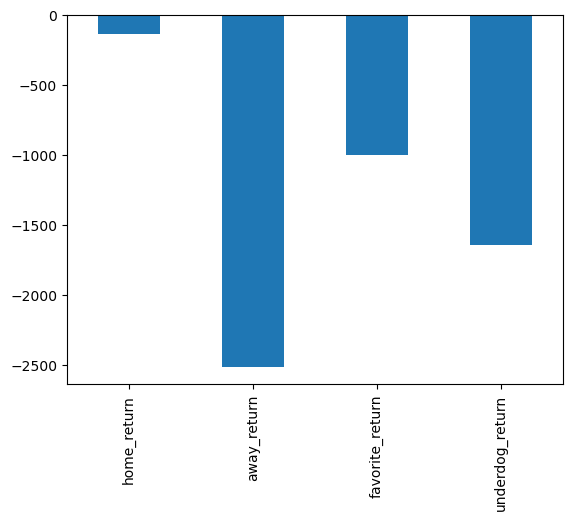

In [75]:
test_with_lines.sum()[['home_return', 'away_return', 'favorite_return', 'underdog_return']].plot.bar()

In [76]:
def get_returns_home_favorite(game):
    if game.home_moneyline < game.away_moneyline:
        return game.favorite_return
    else:
        return 0
    
def get_returns_home_underdog(game):
    if game.home_moneyline > game.away_moneyline:
        return game.underdog_return 
    else:
        return 0
    
def get_returns_away_favorite(game):
    if game.home_moneyline < game.away_moneyline:
        return 0
    else:
        return game.favorite_return
    
def get_returns_away_underdog(game):
    if game.home_moneyline > game.away_moneyline:
        return 0
    else:
        return game.underdog_return 

test_with_lines['return_home_favorite'] = test_with_lines.apply(lambda x: get_returns_home_favorite(x), axis=1)
test_with_lines['return_away_favorite'] = test_with_lines.apply(lambda x: get_returns_away_favorite(x), axis=1)
test_with_lines['return_home_underdog'] = test_with_lines.apply(lambda x: get_returns_home_underdog(x), axis=1)
test_with_lines['return_away_underdog'] = test_with_lines.apply(lambda x: get_returns_away_underdog(x), axis=1)
test_with_lines

,date,home_team,away_team,home_score,away_score,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_return_home_favorite,algo_return_away_favorite,algo_return_home_underdog,algo_return_away_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc,return_home_favorite,return_away_favorite,return_home_underdog,return_away_underdog
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.870911,0.129089,0.325457,-0.370911,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-100.00,0.00,0.0,100.0
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.572215,0.427785,0.006998,-0.048406,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,76.92,0.00,0.0,-100.0
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.856845,0.143155,0.190179,-0.227216,50.00,50.00,0.0,50.00,0.0,50.00,0.0,0.0,0.0,1.0,NaN,1.0,NaN,50.00,0.00,0.0,-100.0
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.882335,0.117665,0.160113,-0.199796,-100.00,-100.00,0.0,-100.00,0.0,-100.00,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-100.00,0.00,0.0,215.0
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,0,0.455943,0.544057,-0.335724,0.294057,-100.00,0.00,-100.0,0.00,-100.0,0.00,0.0,0.0,-100.0,NaN,0.0,NaN,0.0,26.32,0.00,0.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-09-11,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,1,Chicago Bears,San Francisco 49ers,1,0,0.234202,0.765798,-0.068828,0.024865,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.00,-100.00,230.0,0.0
238,2022-09-11,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,1,Detroit Lions,Philadelphia Eagles,0,0,0.429646,0.570354,0.090663,-0.133788,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.00,42.02,-100.0,0.0
239,2022-09-11,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,1,Miami Dolphins,New England Patriots,1,1,0.888267,0.111733,0.255914,-0.288267,58.14,58.14,0.0,58.14,0.0,58.14,0.0,0.0,0.0,1.0,NaN,1.0,NaN,58.14,0.00,0

<Axes: >

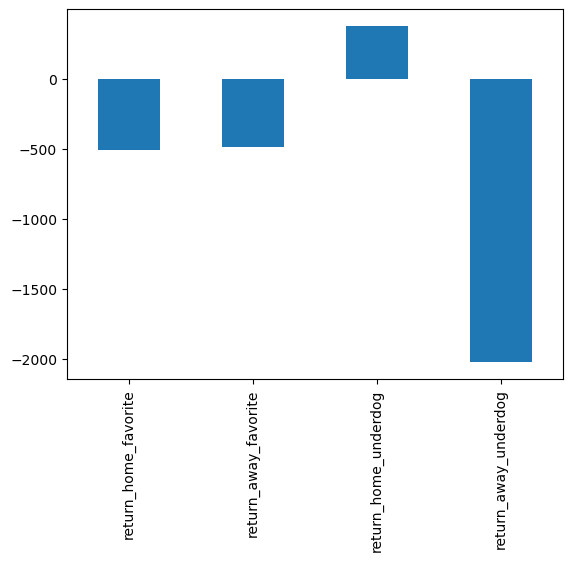

In [77]:
test_with_lines.sum()[['return_home_favorite', 'return_away_favorite', 'return_home_underdog', 'return_away_underdog']].plot.bar()

<Axes: >

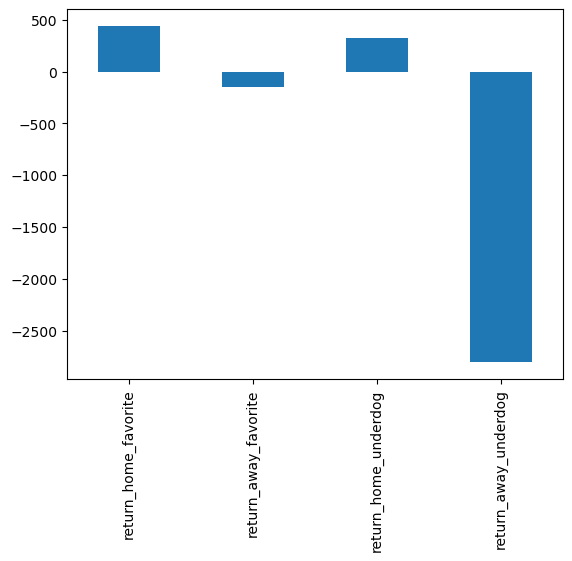

In [87]:
test_with_lines[test_with_lines.home_win_prob >= .5].sum()[['return_home_favorite', 'return_away_favorite', 'return_home_underdog', 'return_away_underdog']].plot.bar()